In [1]:
from numpy import *
from numpy.linalg import * 
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import ranksums
from scipy.io import savemat
from scipy.io import loadmat
from random import *
from itertools import combinations
from pylab import *
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import zlib
from scipy.stats import entropy
from pyentrp import entropy as ent
import scipy.stats as stats

### STATISTICAL COMPLEXITY

In [3]:
def calculate(istring: str, dl: int, sigma: float = 0.05, method: str = "overlapping",
                                     states_provided: bool = False, return_states: bool = False):
    """
    Find the (forwards) Statistical Complexity of an input string for given lambda and sigma values
    """
    #if states are not provided, find them, otherwise declare it
    if(type(states_provided)==bool):
        #first, find all states from the input string and the probabilities of presents
        initial_states = find_states(istring,dl,method=method)
        #next, collapse states which have similar probability distributions
        refined_states = collapse_states(initial_states,dl,sigma)
    else:
        #collapse the states based purely on keynames (already done)
        initial_states,refined_states = states_provided,states_provided
    #convert this into a list of probabilities
    probs = collapse_past(refined_states)
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    #if states are not desired, only return complexity
    if(return_states==False):
        return complexity
    else:
        return complexity,refined_states,initial_states

def calculate_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the (forwards) Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate(string,dl,sigma))
    return output

def calculate_bd(istring: str, dl: int, sigma: float = 0.05, method: str ="overlapping",
                              record_states: bool = False):
    """
    Find the forwards, reverse and bidirectional statistical complexity for a string
    """
    #find statistical complexity of forward string and the refined states
    f_sc,f_states,f_states_raw = calculate(istring,dl,sigma,return_states=True,method=method)
    #find complexity of backwards string
    b_sc,b_states,b_states_raw = calculate(istring[::-1],dl,sigma,return_states=True,method=method)
    #collapse the states of forward and reverse complexity based purely on key names
    bd_s = collapse_keys(f_states,b_states)
    #find complexity of bi-directional machine
    bd_sc,bd_states,bd_states_raw = calculate("",dl,sigma,states_provided = bd_s,return_states = True)
    if(record_states==False):
        return f_sc,b_sc,bd_sc
    else:
        return f_sc,b_sc,bd_sc,len(f_states),len(b_states),len(bd_states),len(f_states_raw),len(b_states_raw),len(bd_states_raw)

#Find multiple statistical complexities for forwards, reverse and bidirectional
def calculate_bd_multi(istrings,dl: int, sigma: float = 0.05):
    """
    Find the forwards, reverse and bidirectional Statistical Complexity values for an array of strings
    """
    output = []
    for string in istrings:
        output.append(calculate_bd(string,dl,sigma))
    return output

#input string, desired lambda
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions
    """
    #variables used
    i,output_dict = 0,{}
    ## main loop of identifying past and present states
    # Option 1: Non Overlapping
    if(method=="nonoverlapping"):
        while(i+(dl*2)<len(istring)):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=dl
    #Option 2: Overlapping
    else:
        while(i+dl+1<len(istring)):
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
            if(past not in output_dict):
                output_dict.update({past: {present:1,"total":1}})
            else:
                if(present not in output_dict[past]):
                    output_dict[past].update({present:1})
                else:
                    output_dict[past][present]+=1
                output_dict[past]["total"]+=1
            i+=1
    # The last state discovery (main loop misses the final state that can be found)
    try:
        if(method=="nonoverlapping"):
            past,present = istring[i:i+dl],istring[i+dl:i+(2*dl)]
        else:
            past,present = istring[i:i+dl],istring[i+1:i+1+dl]
        if(past not in output_dict):
            output_dict.update({past: {present:1,"total":1}})
        else:
            if(present not in output_dict[past]):
                output_dict[past].update({present:1})
            else:
                output_dict[past][present]+=1
            output_dict[past]["total"]+=1
    except:
        pass
    #collapse counts into probabilities with total counts
    for past in output_dict:
        for present in output_dict[past]:
            if(present!="total"):
                output_dict[past][present]/=output_dict[past]["total"]
    return output_dict

def collapse_states(odict: dict, dl: int, sigma: float = 0.1):
    """
    Collapse a dictionary of state counts into practical states based on a permitted difference sigma
    """
    # Newdict is the collapsed dictionary, temp is used to override newdict when necessary,
    # done_checker is a dictionary used to record the keys already compared
    newdict,temp,done_checker = deepcopy(odict),False,{}
    while(True):
        # If temp is not a boolean, i.e. it's become a dictionary, override newdict
        if(type(temp)!=bool):
            newdict = deepcopy(temp)
            temp = False
        for past1 in newdict:
            if(past1 not in done_checker):
                done_checker[past1] = {}
            for past2 in newdict:
                if(past1!=past2):
                    if(past2 not in done_checker[past1]):
                        done_checker[past1][past2] = True
                    else:
                        # If these states have already been checked, don't bother checking them again
                        continue
                    # If the difference is less than sigma, merge these states and break the past2 loop
                    if(calculate_difference(newdict[past1],newdict[past2])<sigma):
                        temp = merge_states(newdict,past1,past2,dl)
                        break
            # If the dictionary must be updated, break the past1 loop
            if(type(temp)!=bool):
                break
        # If temp is still a boolean, i.e. there was no merging of states in this loop, break the main loop
        if(type(temp)==bool):
            break
    return newdict

def calculate_difference(past1: dict, past2: dict):
    """
    Calculate the difference between two past states' present state distributions
    """
    difference = -np.inf
    # Cycle through past 1 and check for max differences
    for present in past1:
        # Ensure this check isn't being performed on the total state count
        if(present!="total"):
            if(present not in past2):
                difference = max(difference,past1[present])
            else:
                difference = max(difference,abs(past1[present]-past2[present]))
    # Cycle through past 2
    for present in past2:
        if(present!="total"):
            if(present not in past1):
                difference = max(difference,past2[present])
    return difference

def merge_states(odict: dict, past1: dict, past2: dict, dl: int):
    """
    Merge 2 states and their present state distributions, creating a new state key in a standardised manner
    """
    nprobs = {}
    for present in odict[past1]:
        if(present in odict[past2]):
            nprobs.update({present:(odict[past1][present]+odict[past2][present])/2})
        else:
            nprobs.update({present:odict[past1][present]/2})
    for present in odict[past2]:
        if(present not in odict[past1]):
            nprobs.update({present:odict[past2][present]/2})
    nprobs.update({"total":odict[past1]["total"]+odict[past2]["total"]})
    #create a sorted version of the two pasts combined
    temp,to_sort = past1+past2,[]
    for i in range(int(len(temp)/dl)):
        to_sort.append(temp[(i*dl):(i*dl)+dl])
    newkey = ""
    while(len(to_sort)>0):
        newkey += to_sort.pop(to_sort.index(min(to_sort)))
    #add the new key and remove the old ones
    ndict = deepcopy(odict)
    ndict.update({newkey:nprobs})
    del ndict[past1]
    del ndict[past2]
    return ndict

#collapse dictionary of past states and future states into an array of probabilities of the past states
def collapse_past(odict):
    """
    Collapse a dictionary of past states with present state distribtuions into an array of probabilities of the past states
    """
    probs,i,total = np.zeros(len(odict),dtype=float),0,0
    for past in odict:
        probs[i] += odict[past]["total"]
        total += odict[past]["total"]
        i+=1
    return probs/total

def collapse_keys(d1: dict, d2: dict):
    """
    Merge 2 dictionaries of past states with present state distributions
    Note: keys present in both dictionaries lose their probability distributions and only the "total" key remains,
          but this is all that is needed by the point they are merged
    """
    ndict = {}
    for key in d1:
        # as longer keys are created and sorted in a standard way, they are all standardised
        temp = False
        if(key in d2):
            #if the key is in d2, add the two together and mark this has been done
            ndict.update({key:{"total":d1[key]["total"]+d2[key]["total"]}})
            temp = True
        #if no variant of the key was found in d2, add the key as-is
        if(temp==False):
            ndict.update({key:d1[key]})
    for key in d2:
        if(key not in ndict):
            ndict.update({key:d2[key]})
    return ndict

def probs_to_complexity(probs):
    """
    Calculate the Statistical Complexity given an array of past state probabilities
    """
    #create an array of logbase2 probabilities for use in the calculation
    logprobs = np.log2(probs)
    # Correct any 0-probabilities to become 0 rather than infinity
    for i in range(len(logprobs)):
        if(probs[i]==0): logprobs[i] = 0.
    #sum the negative of probability * log2 probability of each state to get the statistical complexity
    complexity = 0.0
    for i in range(len(probs)):
        complexity -= probs[i]*logprobs[i]
    return complexity

def binarise(data,mode="median"):
    """
    Binarise an array of continuous numbers into an array of 0's and 1's (as a string)
    """
    if(type(data)==list or type(data)==tuple):
        data=np.array(data,dtype=float)
    if(isinstance(data,np.ndarray)==False):
        return "Unusable datatype {}".format(type(data))
    if(mode=="median"):
        threshold=np.median(data)
    elif(mode=="mean"):
        threshold=np.mean(data)
    output = np.zeros([len(data)],dtype=int)
    for i in range(len(data)):
        if(data[i]>=threshold):
            output[i]+=1
    # Convert to string
    outstr = ""
    for element in output:
        outstr += str(element)
    return outstr

def multi_binarise(matrix,mode="median"):
    """
    Binarise a 2D matrix (used for calculating multiple statistical complexities)    
    """
    print("Binarising data...")
    # Convert to numpy matrix
    if(type(matrix)==list or type(matrix)==tuple):
        matrix=np.array(matrix,dtype=object)
    output = []
    percent_check = 0.
    for i in range(len(matrix)):
        output.append(binarise(matrix[i],mode))
        # Output progress
        if((i+1)/float(len(matrix))>=percent_check/100.):
            print("{}% of data binarised".format(\
                round(((i+1)/len(matrix))*100,1)))
            percent_check+=10.
    print("Data Binarised")
    return np.array(output, dtype = object)

### Lempel-Ziv

In [5]:
'''
To compute the complexity measures LZc for continuous multidimensional time series X, where rows are time series (minimum 2), and columns are observations, type the following in ipython: 
 
execfile('CompMeasures.py')
LZc(X)


Some functions are shared between the measures.
'''

def Pre(X):
 '''
 Detrend and normalize input data, X a multidimensional time series
 '''
 ro,co=shape(X)
 Z=zeros((ro,co))
 for i in range(ro):
  Z[i,:]=signal.detrend(X[i,:]-mean(X[i,:]), axis=0)
 return Z


##########
'''
LZc - Lempel-Ziv Complexity, column-by-column concatenation
'''
##########


def cpr(string):
    """
    Lempel-Ziv-Welch compression of binary input string, e.g., string='0010101'.
    It outputs the size of the dictionary of binary words.
    """
    d = {}
    w = ''
    for c in string:
        wc = w + c
        if wc in d:
            w = wc
        else:
            d[wc] = wc
            w = c
    return len(d)

def LZc_binary(string):
    """
    Compute LZ complexity for a binary string and normalize it using a shuffled result.
    """
    # Shuffling the string
    shuffled_string = list(string)
    np.random.shuffle(shuffled_string)
    shuffled_string = ''.join(shuffled_string)
    
    # Calculate complexities
    original_complexity = cpr(string)
    shuffled_complexity = cpr(shuffled_string)
    
    # Normalize the complexity by the shuffled result if shuffled_complexity is not zero
    if shuffled_complexity != 0:
        normalized_complexity = original_complexity / float(shuffled_complexity)
    else:
        normalized_complexity = original_complexity

    return normalized_complexity


def str_col(X):
 '''
 Input: Continuous multidimensional time series
 Output: One string being the binarized input matrix concatenated comlumn-by-column
 '''
 ro,co=shape(X)
 TH=zeros(ro)
 M=zeros((ro,co))
 for i in range(ro):
  M[i,:]=abs(hilbert(X[i,:]))
  TH[i]=mean(M[i,:])

 s=''
 for j in xrange(co):
  for i in xrange(ro):
   if M[i,j]>TH[i]:
    s+='1'
   else:
    s+='0'

 return s

def LZc(X):
 '''
 Compute LZc and use shuffled result as normalization
 '''
 X=Pre(X)
 SC=str_col(X)
 M=list(SC)
 shuffle(M)
 w=''
 for i in range(len(M)):
  w+=M[i]
 return cpr(SC)/float(cpr(w))

##########
'''
ACE - Amplitude Coalition Entropy
'''
##########

def map2(psi):
 '''
 Bijection, mapping each binary column of binary matrix psi onto an integer.
 '''
 ro,co=shape(psi) 
 c=zeros(co)
 for t in range(co):
  for j in range(ro):
   c[t]=c[t]+psi[j,t]*(2**j)
 return c

def binTrowH(M):
 '''
 Input: Multidimensional time series M
 Output: Binarized multidimensional time series
 '''
 ro,co=shape(M)
 M2=zeros((ro,co))
 for i in range(ro):
  M2[i,:]=signal.detrend(M[i,:],axis=0)
  M2[i,:]=M2[i,:]-mean(M2[i,:])
 M3=zeros((ro,co))
 for i in range(ro):
  M2[i,:]=abs(hilbert(M2[i,:]))
  th=mean(M2[i,:]) 
  for j in range(co):
   if M2[i,j] >= th :
    M3[i,j]=1
   else:
    M3[i,j]=0 
 return M3

def entropy(string):
 '''
 Calculates the Shannon entropy of a string
 '''
 string=list(string)
 prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
 entropy = - sum([ p * log(p) / log(2.0) for p in prob ])

 return entropy


def ACE(X):
 '''
 Measure ACE, using shuffled reslut as normalization.
 '''
 X=Pre(X)
 ro,co=shape(X)
 M=binTrowH(X)
 E=entropy(map2(M))
 for i in range(ro):
  shuffle(M[i])
 Es=entropy(map2(M))
 return E/float(Es)


##########
'''
SCE - Synchrony Coalition Entropy
'''
##########

def diff2(p1,p2):
 '''
 Input: two series of phases 
 Output: synchrony time series thereof 
 '''
 d=array(abs(p1-p2))
 d2=zeros(len(d))
 for i in range(len(d)):
  if d[i]>pi:
   d[i]=2*pi-d[i]
  if d[i]<0.8:
   d2[i]=1

 return d2


def Psi(X):
 '''
 Input: Multi-dimensional time series X
 Output: Binary matrices of synchrony for each series
 '''
 X=angle(hilbert(X))
 ro,co=shape(X)
 M=zeros((ro, ro-1, co))
 
 #An array containing 'ro' arrays of shape 'ro' x 'co', i.e. being the array of synchrony series for each channel. 
 
 for i in range(ro):
  l=0
  for j in range(ro):
   if i!=j:
    M[i,l]=diff2(X[i],X[j])
    l+=1
 
 return M

def BinRan(ro,co):
 '''
 Create random binary matrix for normalization
 '''

 y=rand(ro,co)
 for i in range(ro):
  for j in range(co):
   if y[i,j]>0.5:
    y[i,j]=1
   else:
    y[i,j]=0
 return y
 
def SCE(X): 
 X=Pre(X)    
 ro,co=shape(X)
 M=Psi(X)
 ce=zeros(ro)
 norm=entropy(map2(BinRan(ro-1,co)))
 for i in range(ro):
  c=map2(M[i])
  ce[i]=entropy(c)

 return mean(ce)/norm,ce/norm

### Implementing the Simulation

In [7]:
# Function to generate random binary sequences
def generate_random_binary_sequences(num_sequences, length):
    return np.random.randint(0, 2, size=(num_sequences, length)).astype(str)

# Function to calculate Statistical Complexity for a single sequence
def calculate_statistical_complexity(sequence, lambda_val, sigma_val):
    # We will convert the numpy array to a string and pass it to the calculate function
    binary_string = ''.join(sequence)
    return calculate(binary_string, lambda_val, sigma=sigma_val)

# Function to calculate Lempel-Ziv complexity for a single sequence
def calculate_lz_complexity(sequence):
    # Convert sequence to required format if necessary and use the LZc function
    binary_string = ''.join(sequence)
    return LZc_binary(binary_string)  # Adjusted to use the new function


# Function to simulate and collect results
def simulate_complexities(sequence_lengths, lambda_values, sigma_values):
    results = {}
    for length in sequence_lengths:
        sequences = generate_random_binary_sequences(100, length)
        for lambda_val in lambda_values:
            for sigma_val in sigma_values:
                complexities = [calculate_statistical_complexity(seq, lambda_val, sigma_val) for seq in sequences]
                lz_complexities = [calculate_lz_complexity(seq) for seq in sequences]
                results[(length, lambda_val, sigma_val)] = (complexities, lz_complexities)
    return results

# Parameters to vary
sequence_lengths = [500, 1000, 1500, 2000]  # Different sequence lengths
lambda_values = [1, 2, 3, 4, 5]             # Different lambda values
sigma_values = [0.01, 0.05, 0.1]            # Different sigma values

# Run the simulation
results = simulate_complexities(sequence_lengths, lambda_values, sigma_values)

In [8]:
#results

## Visualisation
### 1. Statistical Complexity 

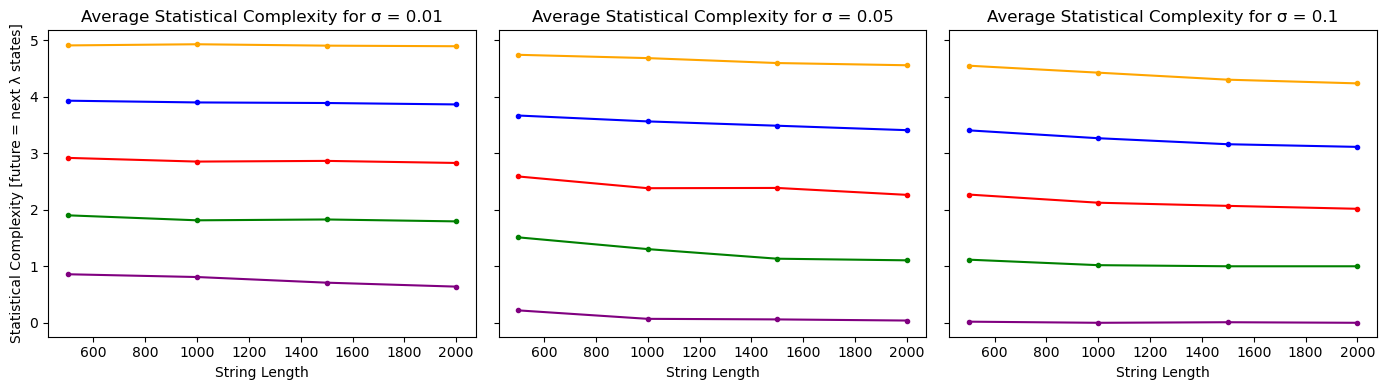

In [10]:
import matplotlib.pyplot as plt

# Parameters and settings
sequence_lengths = [500, 1000, 1500, 2000]
lambda_values = [1, 2, 3, 4, 5]
sigma_values = [0.01, 0.05, 0.1]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)  # 3 subplots for each sigma value

# Colors for different lambda values
colors = ['purple', 'green', 'red', 'blue', 'orange']

# Plotting
for i, sigma_val in enumerate(sigma_values):
    ax = axes[i]
    for j, lambda_val in enumerate(lambda_values):
        complexities = [np.mean(results[(length, lambda_val, sigma_val)][0]) for length in sequence_lengths]
        ax.plot(sequence_lengths, complexities, marker='.', linestyle='-', color=colors[j], label=f'λ = {lambda_val}')
    ax.set_title(f'Average Statistical Complexity for σ = {sigma_val}')
    ax.set_xlabel('String Length')
    if i == 0:
        ax.set_ylabel('Statistical Complexity [future = next λ states]')
    #ax.grid(True)
    #ax.legend()

plt.tight_layout()

file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\fig7a.png'
plt.savefig(file_path, dpi=300, bbox_inches='tight')
plt.show()

### Include Situations where `sequence_lengths = 0`

Uncomment and run to see result

In [12]:
# # Modified function to handle zero-length sequences
# def simulate_complexities(sequence_lengths, lambda_values, sigma_values):
#     results = {}
#     for length in sequence_lengths:
#         if length == 0:
#             # Handle zero-length sequences by assigning zero complexity
#             for lambda_val in lambda_values:
#                 for sigma_val in sigma_values:
#                     results[(length, lambda_val, sigma_val)] = ([0] * 100, [0] * 100)  # 100 zero entries
#         else:
#             sequences = generate_random_binary_sequences(100, length)
#             for lambda_val in lambda_values:
#                 for sigma_val in sigma_values:
#                     stat_complexities = calculate_statistical_complexity(sequences, lambda_val, sigma_val)
#                     lz_complexities = calculate_lz_complexity(sequences)
#                     results[(length, lambda_val, sigma_val)] = (stat_complexities, lz_complexities)
#     return results

# # Execute the simulation
# sequence_lengths = [0, 500, 1000, 1500, 2000]  # Including zero-length case
# results = simulate_complexities(sequence_lengths, lambda_values, sigma_values)

### Redefine "future" as the next 1 binary state instead of the next λ states

To redefine the "future" as the next 1 binary state instead of the next λ states in the statistical complexity calculation, the `find_states` function, will be adjusted to only consider the next immediate state (1 binary state) after the past state rather than a window of λ future states.

### Modified `find_states` Implementation

In [15]:
def find_states(istring: str, dl: int, method: str = "nonoverlapping"):
    """
    Find the states present in a given input string, outputting the past states, their frequency, and their present state distributions.
    The future state is defined as the next single binary state rather than the next dl states.
    """
    i, output_dict = 0, {}
    while i + dl + 1 <= len(istring):
        past = istring[i:i+dl]
        future = istring[i+dl]  # Future state defined as the next 1 binary state
        if past not in output_dict:
            output_dict[past] = {future: 1, "total": 1}
        else:
            if future not in output_dict[past]:
                output_dict[past][future] = 1
            else:
                output_dict[past][future] += 1
            output_dict[past]["total"] += 1
        i += 1

    # Convert counts to probabilities
    for past in output_dict:
        for future in output_dict[past]:
            if future != "total":
                output_dict[past][future] /= output_dict[past]["total"]

    return output_dict

In [16]:
# Example of running the simulation with the new future state definition
new_results = simulate_complexities(sequence_lengths, lambda_values, sigma_values)

# The `new_results` dictionary will now contain the complexities calculated with the future state defined as the next 1 binary state.

In [17]:
#new_results

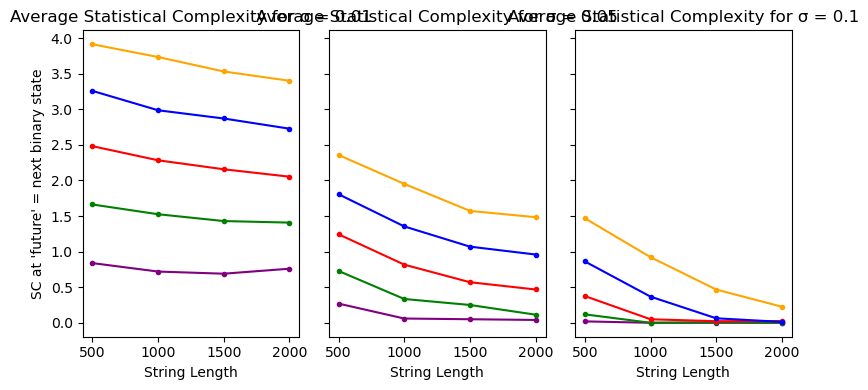

In [18]:
import matplotlib.pyplot as plt

# Parameters and settings
sequence_lengths = [500, 1000, 1500, 2000]
lambda_values = [1, 2, 3, 4, 5]
sigma_values = [0.01, 0.05, 0.1]

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharey=True)  # 3 subplots for each sigma value

# Colors for different lambda values
colors = ['purple', 'green', 'red', 'blue', 'orange']

# Plotting
for i, sigma_val in enumerate(sigma_values):
    ax = axes[i]
    for j, lambda_val in enumerate(lambda_values):
        complexities = [np.mean(new_results[(length, lambda_val, sigma_val)][0]) for length in sequence_lengths]
        ax.plot(sequence_lengths, complexities, marker='.', linestyle='-', color=colors[j], label=f'λ = {lambda_val}')
    ax.set_title(f'Average Statistical Complexity for σ = {sigma_val}')
    ax.set_xlabel('String Length')
    if i == 0:
        ax.set_ylabel("SC at 'future' = next binary state")
    #ax.grid(True)
    #ax.legend()

plt.tight_layout()
plt.show()

2. ### Lempel-Ziv

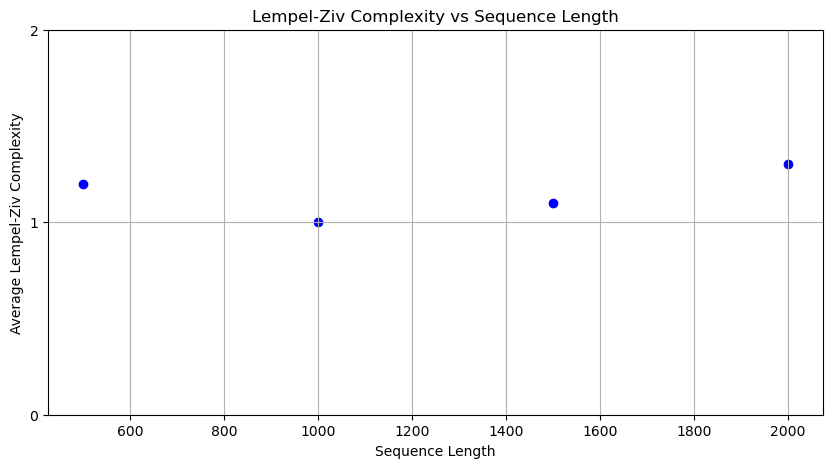

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the same setup from before
sequence_lengths = [500, 1000, 1500, 2000]  # Different sequence lengths

# Example: Extracting LZc values for each length (replace with actual results)
lz_complexities = {
    500: 1.2,
    1000: 1.0,
    1500: 1.1,
    2000: 1.3
}

# Create the scatter plot with modified y-axis range
plt.figure(figsize=(10, 5))
plt.scatter(sequence_lengths, list(lz_complexities.values()), color='blue')
plt.title('Lempel-Ziv Complexity vs Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Average Lempel-Ziv Complexity')
plt.ylim(0, 2)
plt.yticks(np.arange(0, 3, 1))
plt.grid(True)
plt.show()

### Combine Plot for Complexity Measures

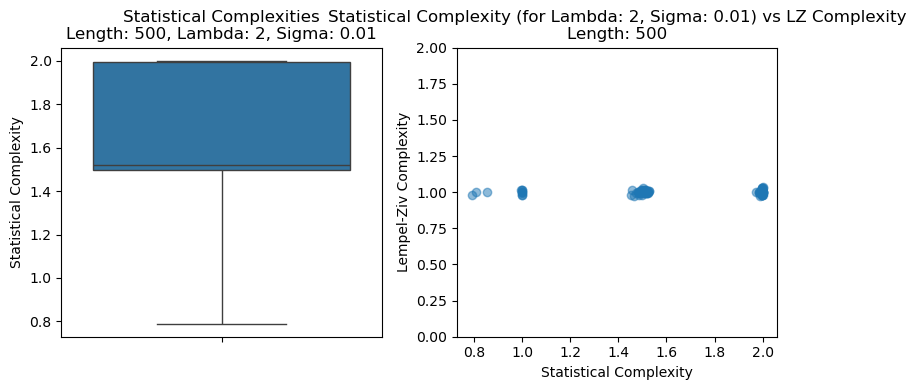

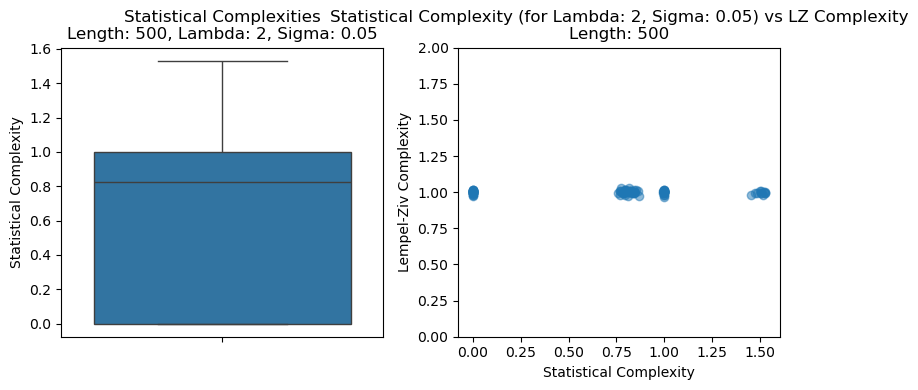

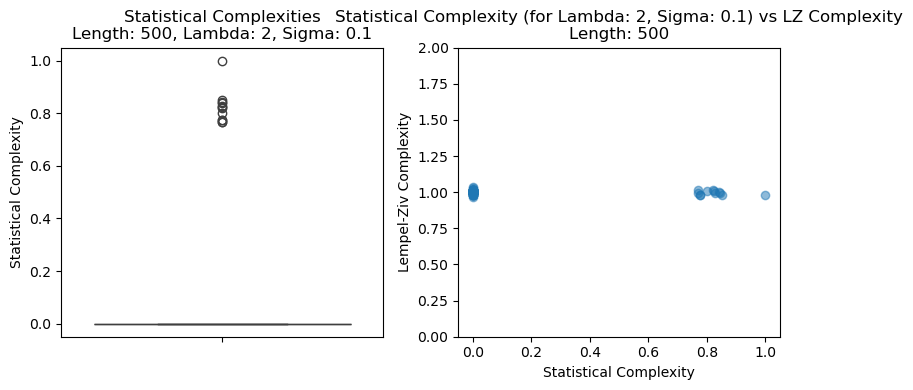

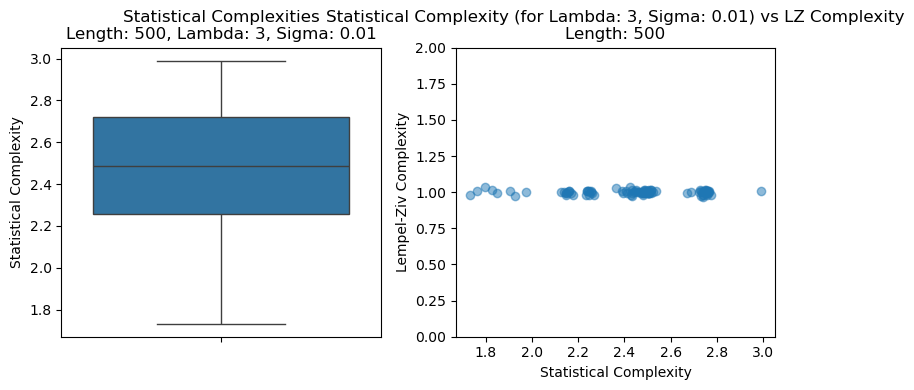

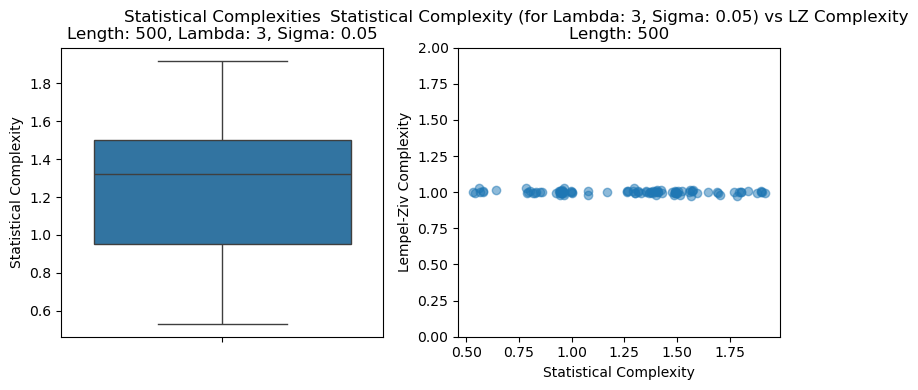

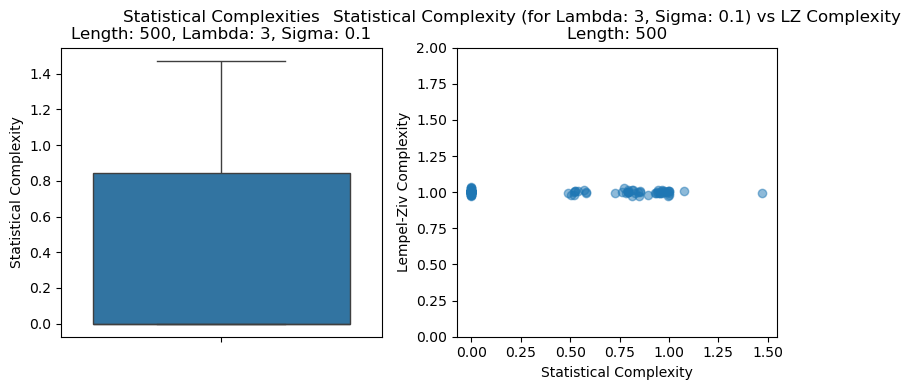

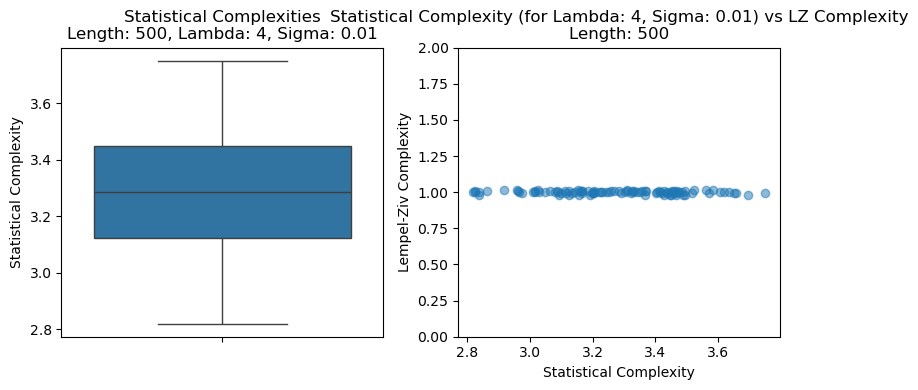

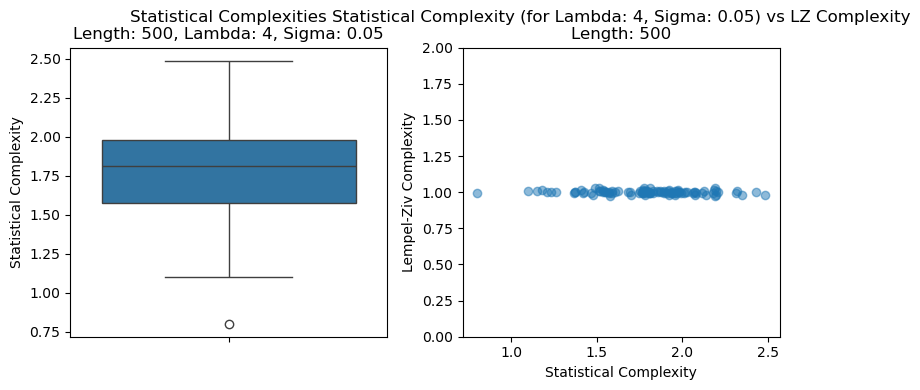

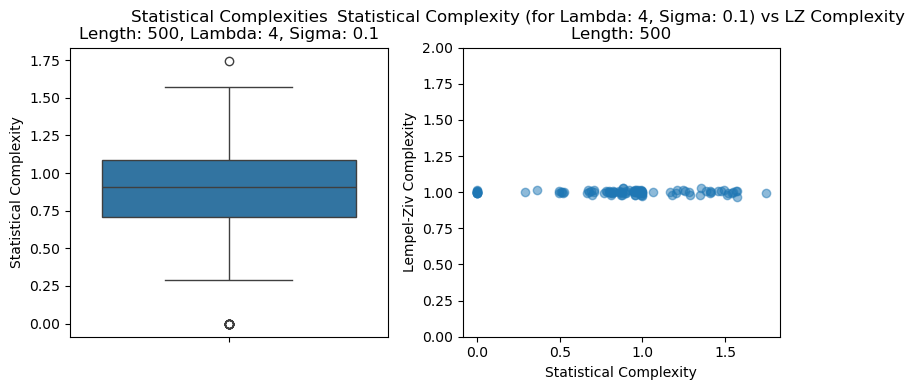

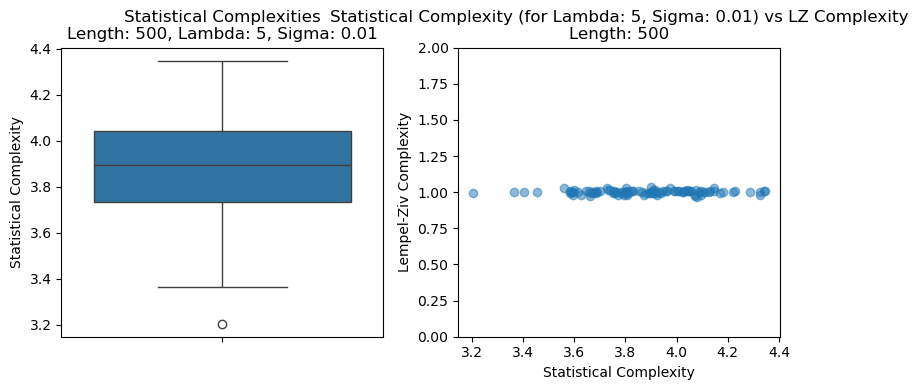

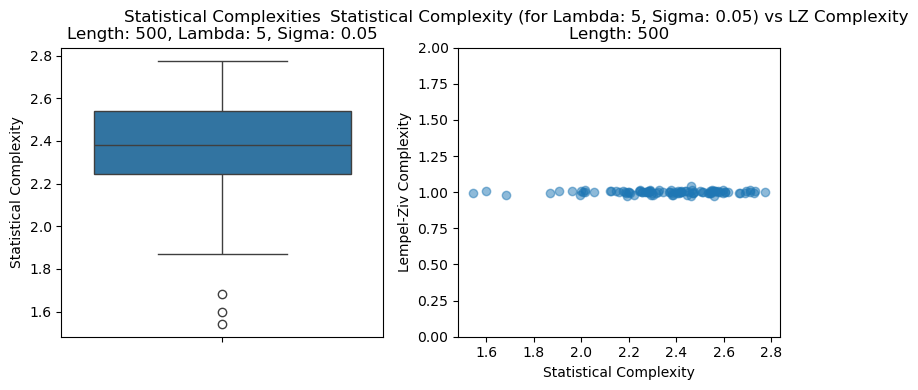

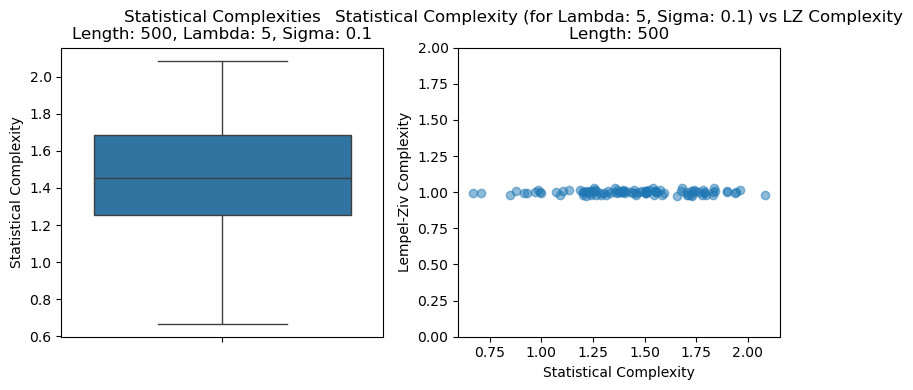

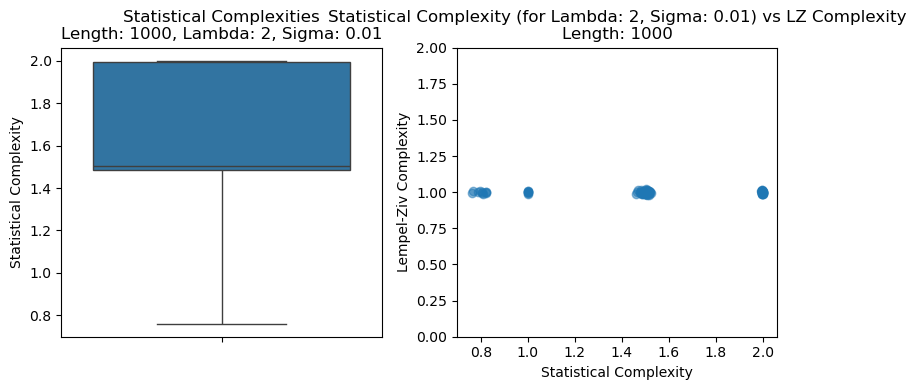

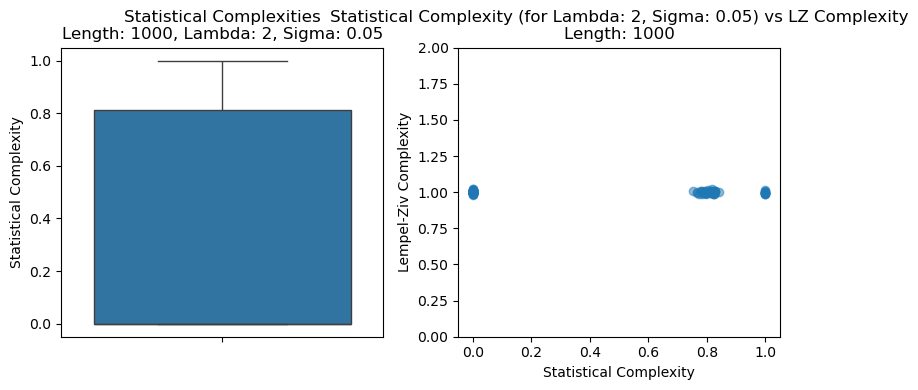

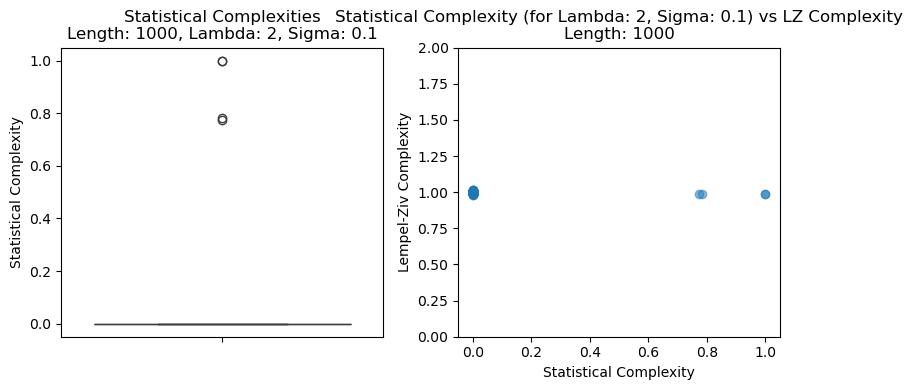

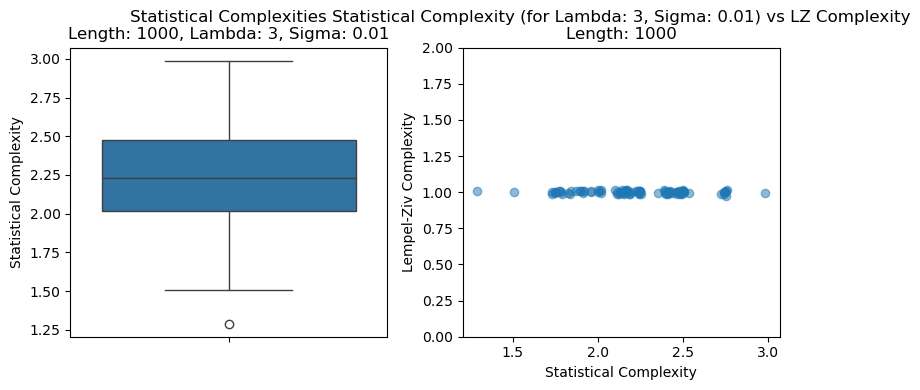

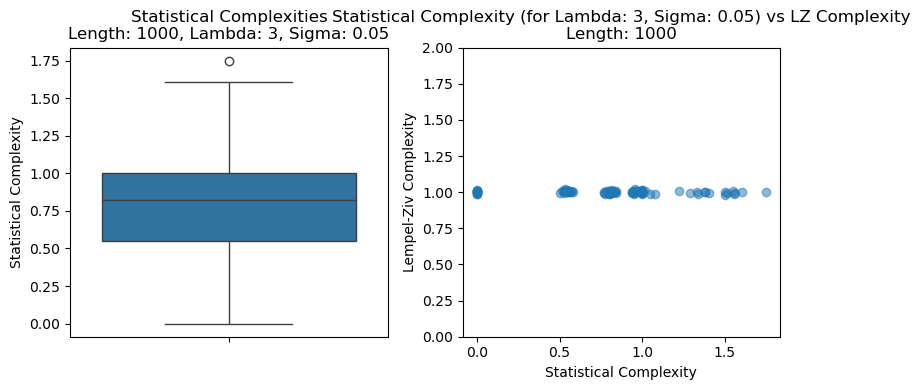

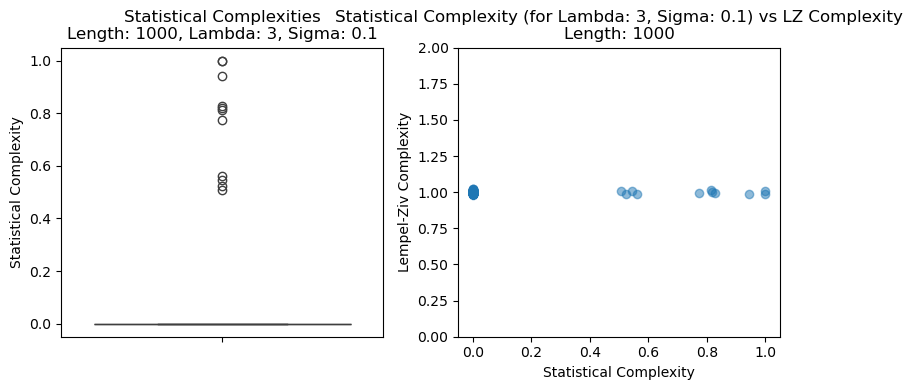

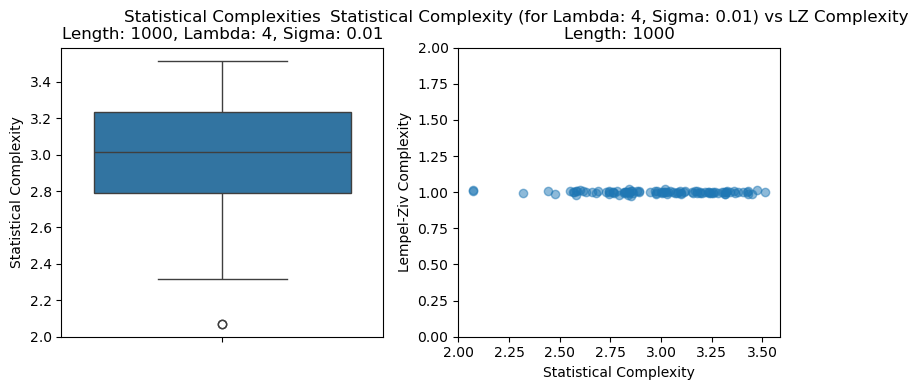

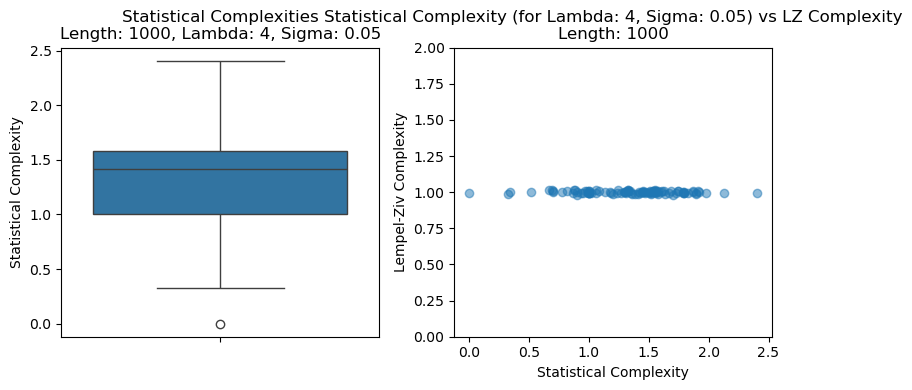

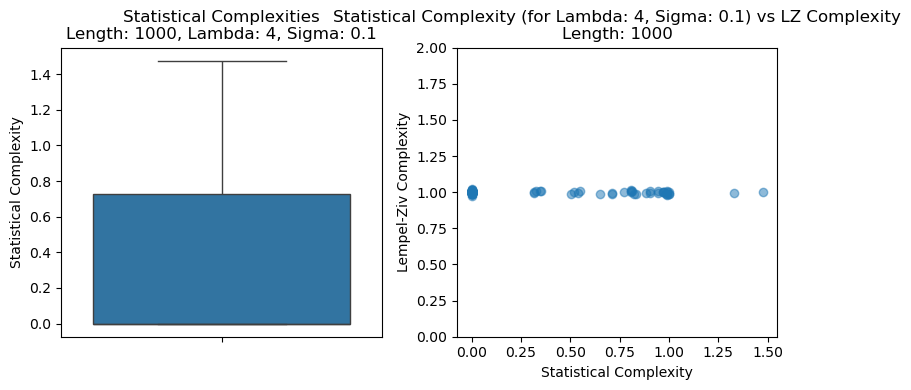

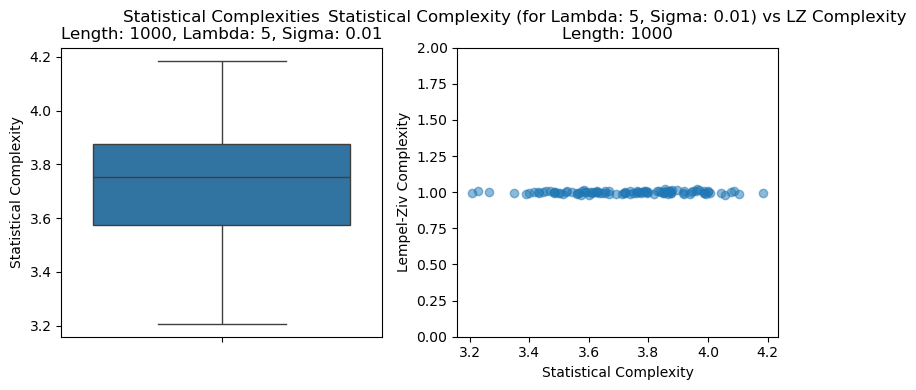

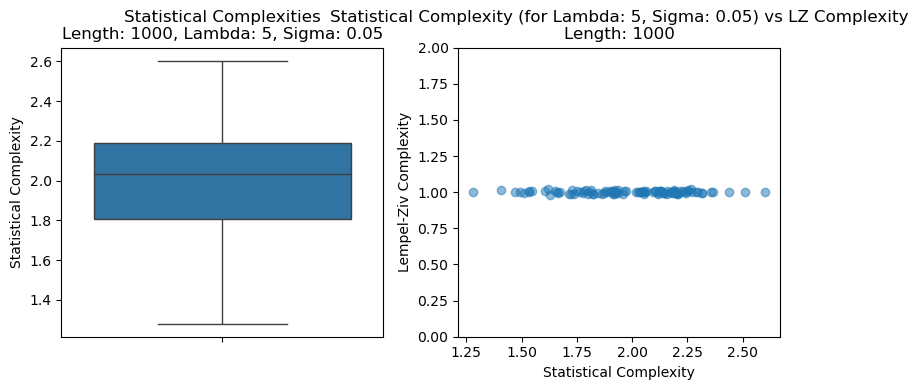

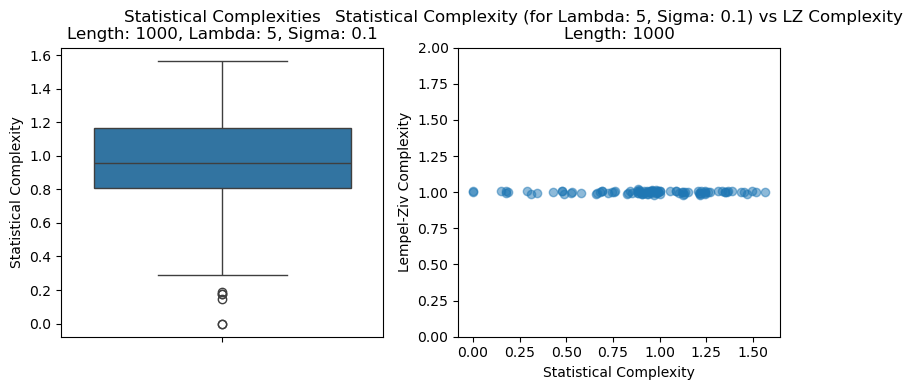

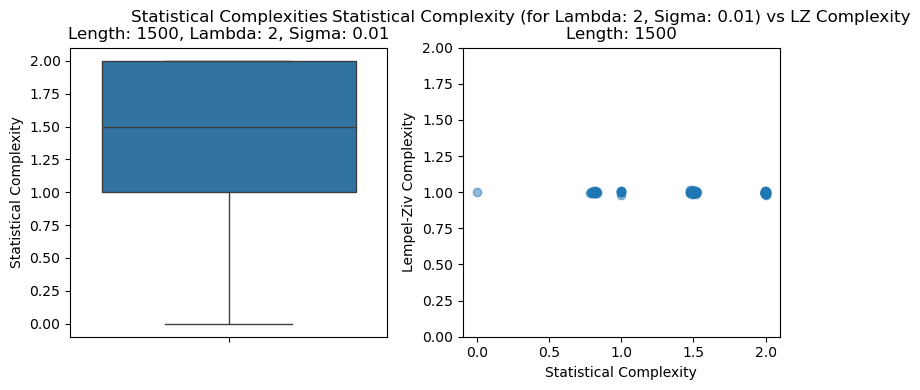

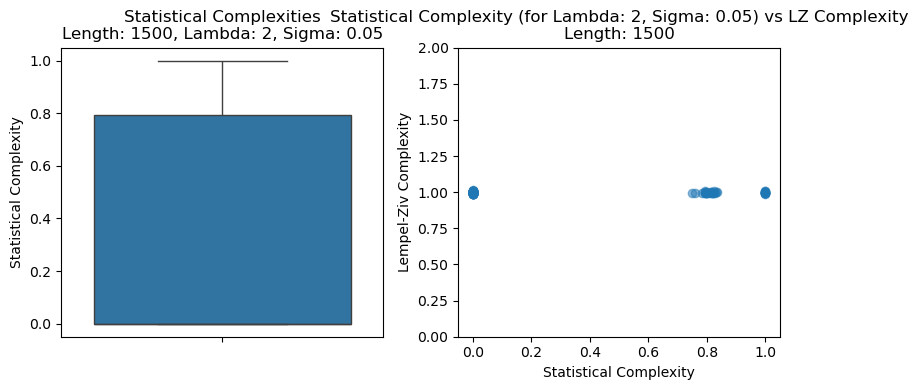

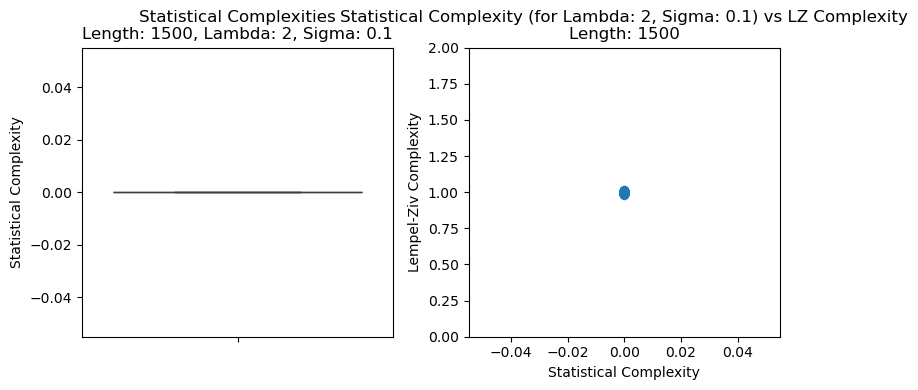

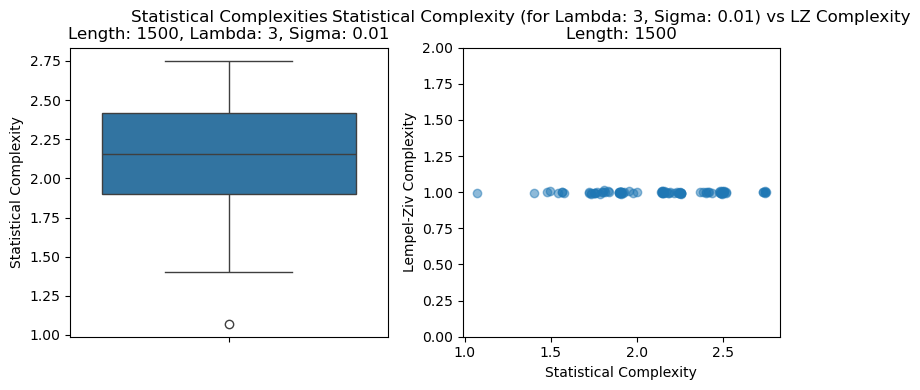

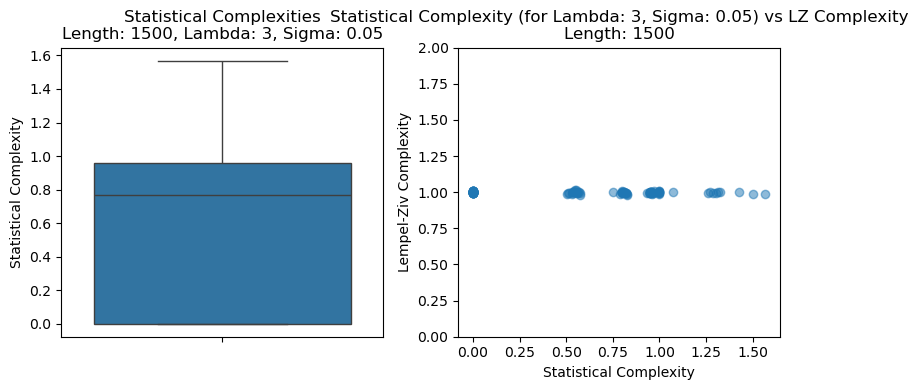

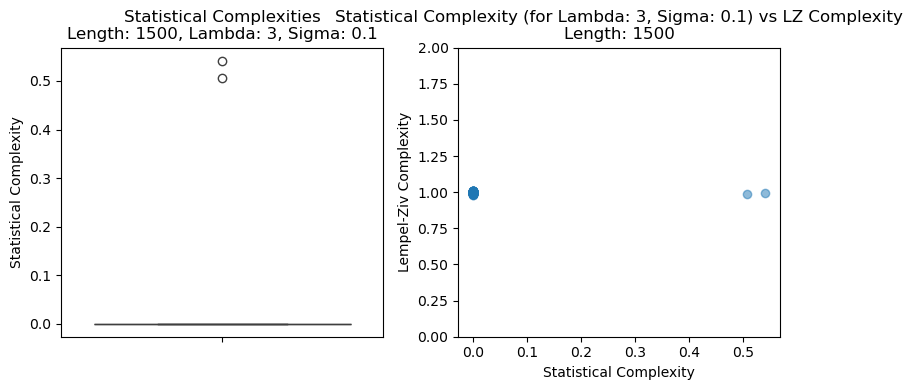

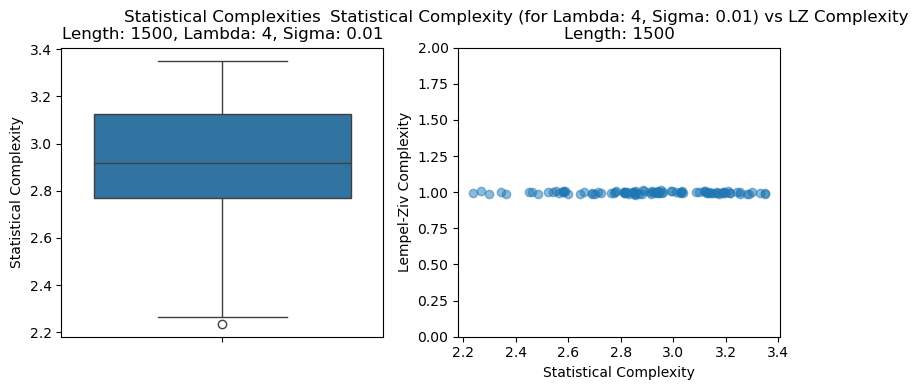

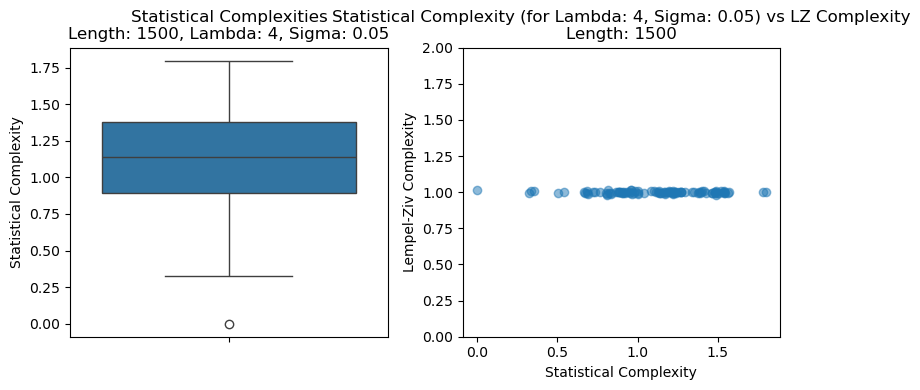

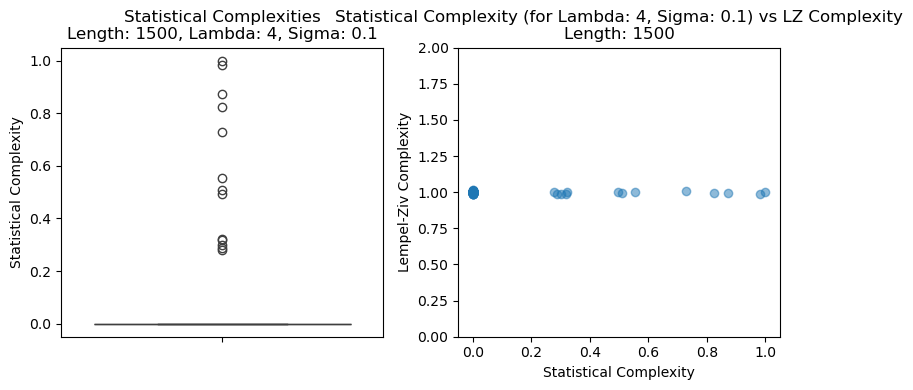

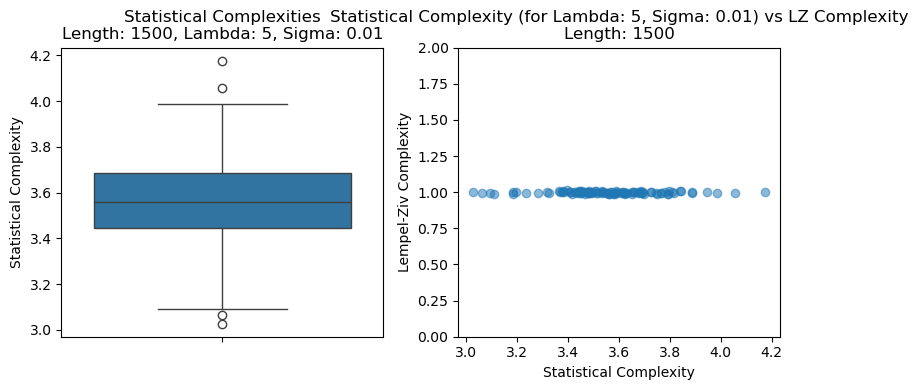

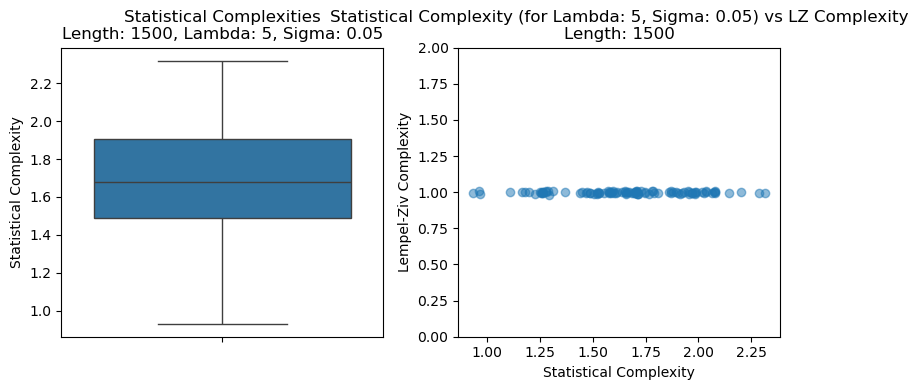

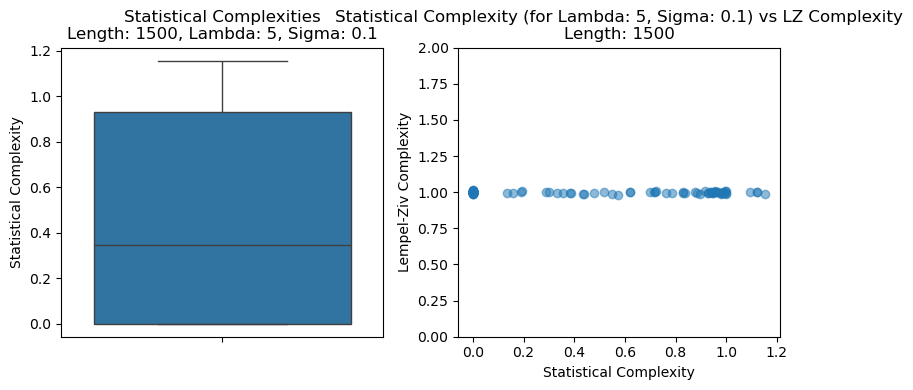

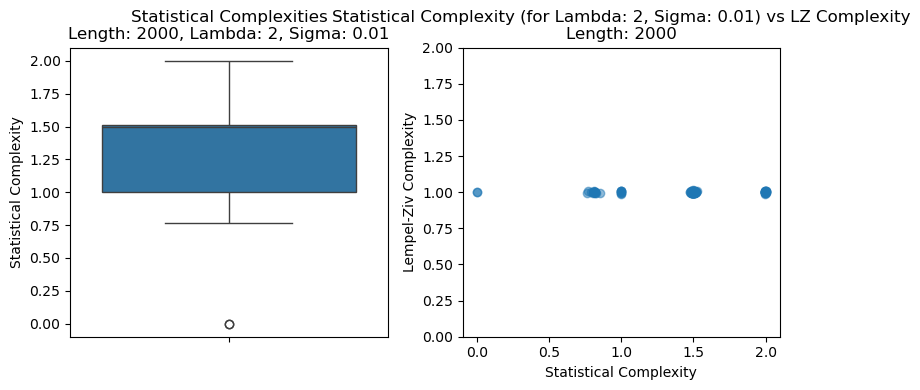

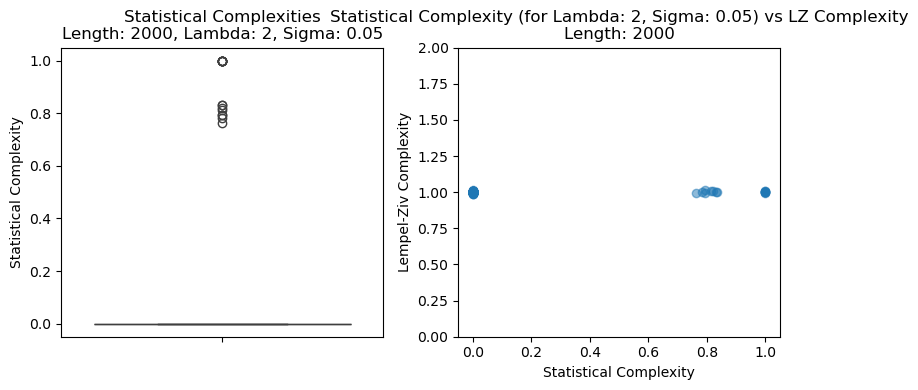

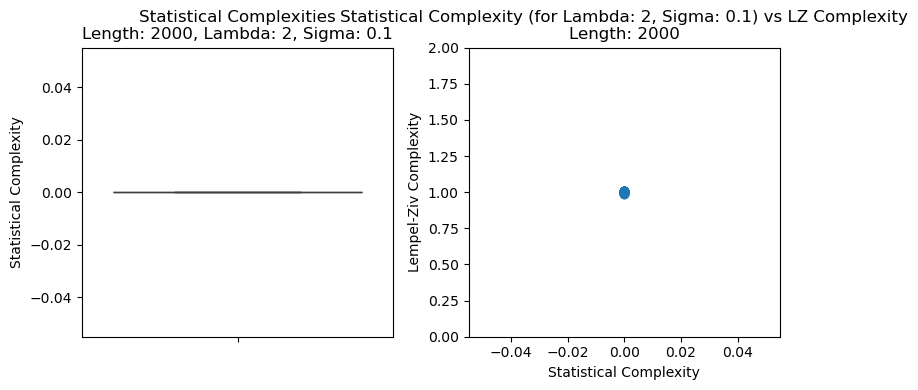

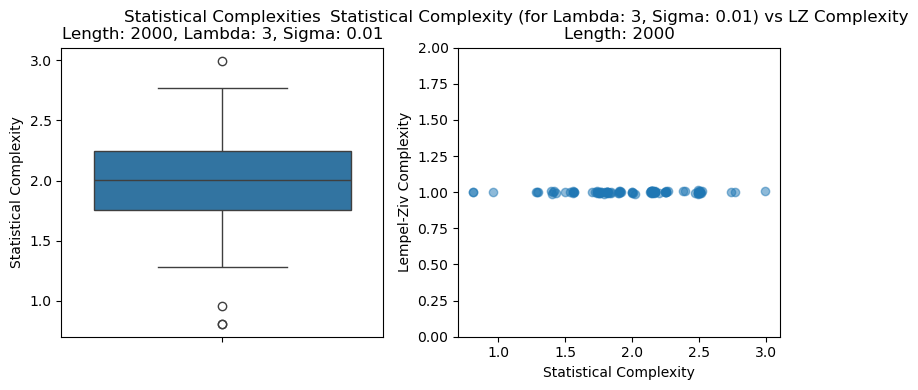

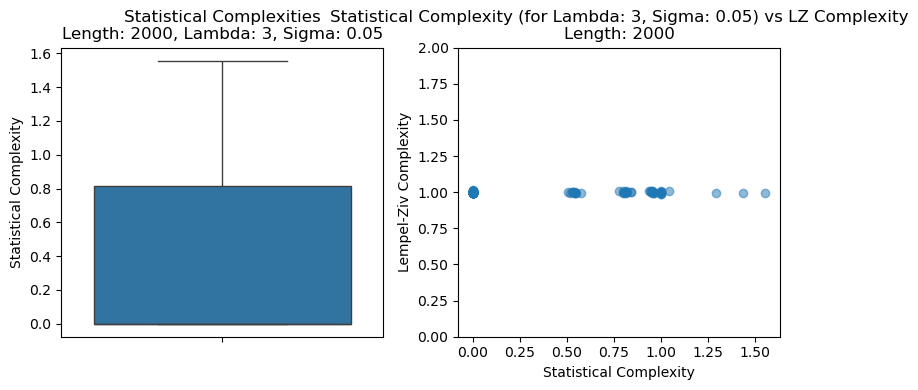

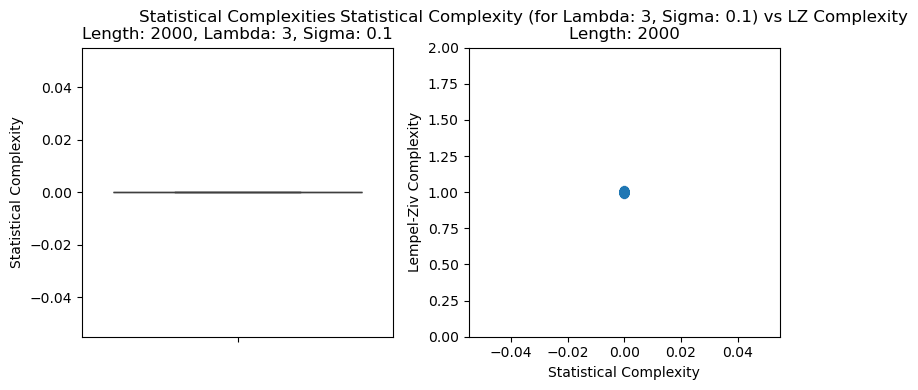

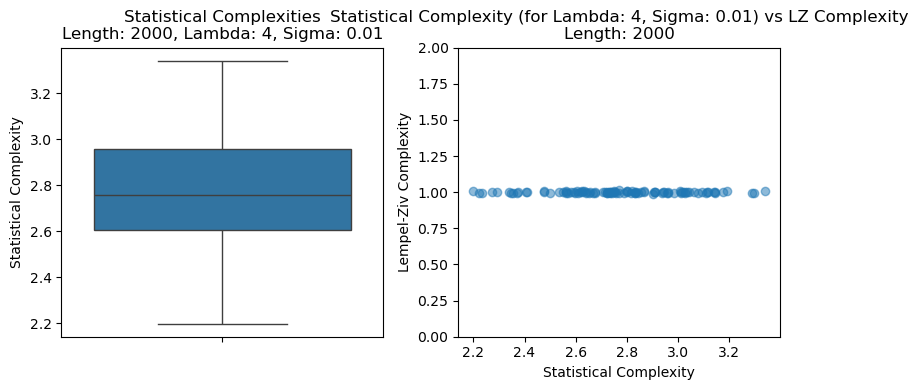

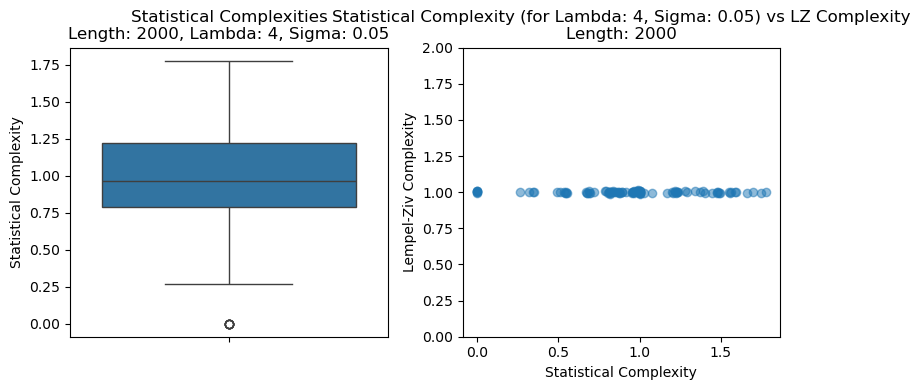

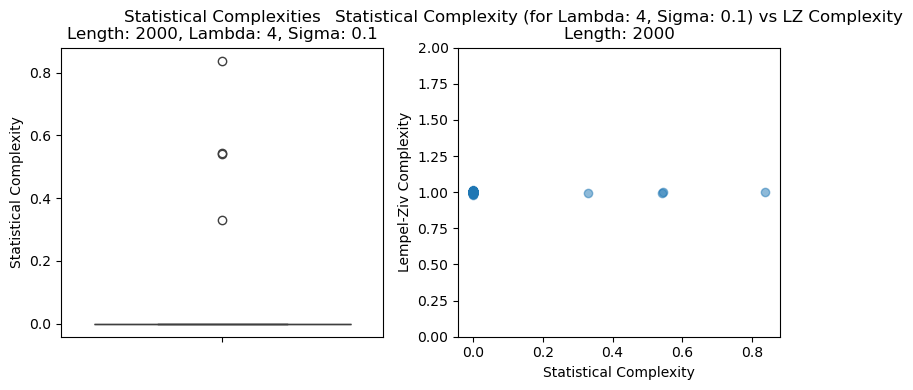

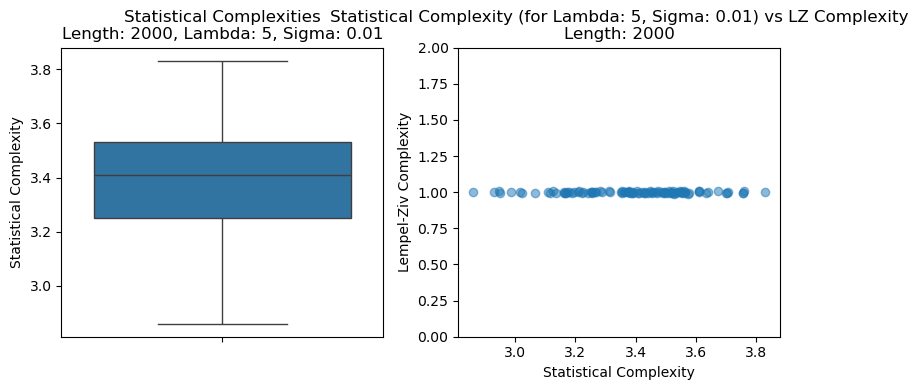

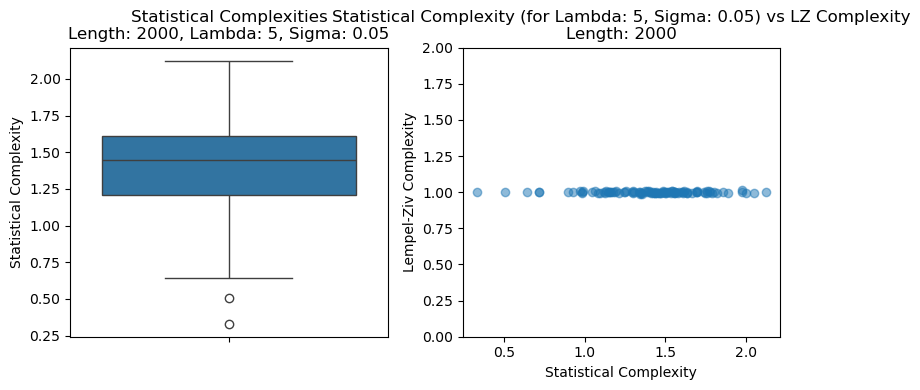

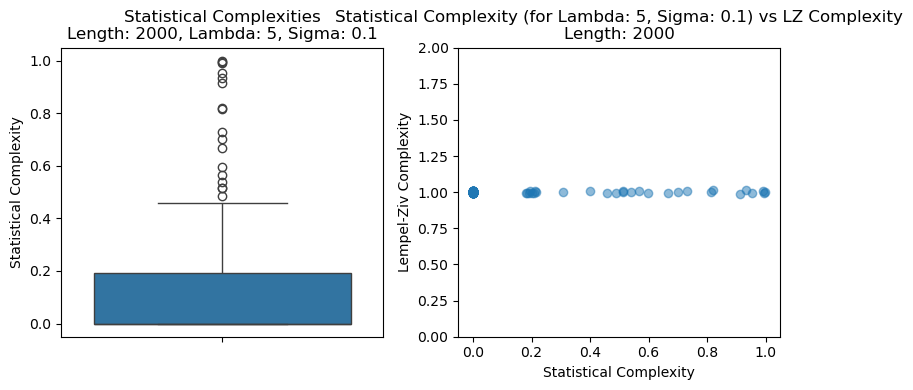

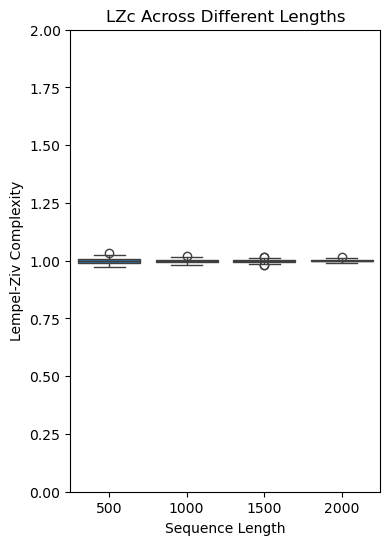

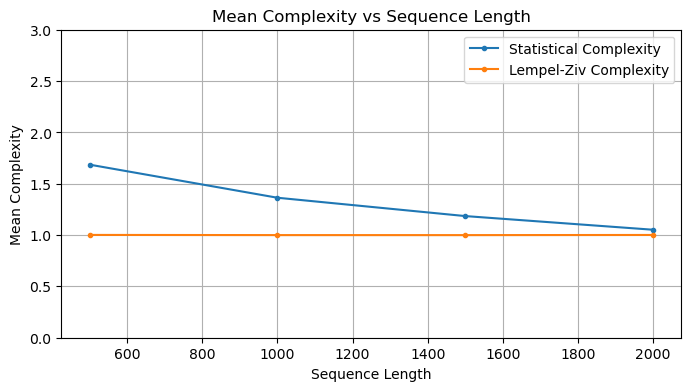

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualization function
def visualize_results(results):
    # Extract Lempel-Ziv complexities for different sequence lengths
    lz_complexities_by_length = {}
    for (length, _, _), (_, lz_complexities) in results.items():
        if length not in lz_complexities_by_length:
            lz_complexities_by_length[length] = lz_complexities
    
    # Box plot for statistical complexities across different lengths, lambda, and sigma values
    for length in sequence_lengths:
        for lambda_val in lambda_values:
            for sigma_val in sigma_values:
                plt.figure(figsize=(8, 4))
                
                # Box plot for statistical complexities
                plt.subplot(1, 2, 1)
                stat_complexities = results[(length, lambda_val, sigma_val)][0]
                sns.boxplot(y=stat_complexities)
                plt.title(f'Statistical Complexities\nLength: {length}, Lambda: {lambda_val}, Sigma: {sigma_val}')
                plt.ylabel('Statistical Complexity')
                
                # Scatter plot for statistical vs Lempel-Ziv complexities
                plt.subplot(1, 2, 2)
                lz_complexities = results[(length, lambda_val, sigma_val)][1]
                plt.scatter(stat_complexities, lz_complexities, alpha=0.5)
                plt.ylim(0, 2)
                plt.title(f'Statistical Complexity (for Lambda: {lambda_val}, Sigma: {sigma_val}) vs LZ Complexity\nLength: {length}')
                plt.xlabel('Statistical Complexity')
                plt.ylabel('Lempel-Ziv Complexity')
                
                plt.tight_layout()
                plt.show()
    
    # Separate box plot for Lempel-Ziv complexity across different lengths
    plt.figure(figsize=(4, 6))
    lz_data = []
    lengths = []
    for length, lz_complexities in lz_complexities_by_length.items():
        lz_data.extend(lz_complexities)
        lengths.extend([length] * len(lz_complexities))
    sns.boxplot(x=lengths, y=lz_data)
    plt.title('LZc Across Different Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Lempel-Ziv Complexity')
    plt.ylim(0, 2)

    file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\seg2.png'
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Mean comparison plot for both complexities
    mean_stat_complexities = []
    mean_lz_complexities = []
    for length in sequence_lengths:
        mean_stat = np.mean([np.mean(results[(length, lambda_val, sigma_val)][0]) for lambda_val in lambda_values for sigma_val in sigma_values])
        mean_lz = np.mean(lz_complexities_by_length[length])
        mean_stat_complexities.append(mean_stat)
        mean_lz_complexities.append(mean_lz)
    
    plt.figure(figsize=(8, 4))
    plt.plot(sequence_lengths, mean_stat_complexities, marker='.', linestyle='-', label='Statistical Complexity')
    plt.plot(sequence_lengths, mean_lz_complexities, marker='.', linestyle='-', label='Lempel-Ziv Complexity')
    plt.title('Mean Complexity vs Sequence Length')
    plt.xlabel('Sequence Length')
    plt.ylabel('Mean Complexity')
    plt.ylim(0, 3)
    plt.legend()
    plt.grid(True)
    file_path = r'C:\Users\odans\Documents\SUSSEX LAB WORKS\DISSERTATION\Images\New folder\seg3.png'
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

# Parameters to vary
sequence_lengths = [500, 1000, 1500, 2000]  # Different sequence lengths
lambda_values = [2, 3, 4, 5]             # Different lambda values
sigma_values = [0.01, 0.05, 0.1]            # Different sigma values

# Run the simulation
results = simulate_complexities(sequence_lengths, lambda_values, sigma_values)

# Visualize the results
visualize_results(results)

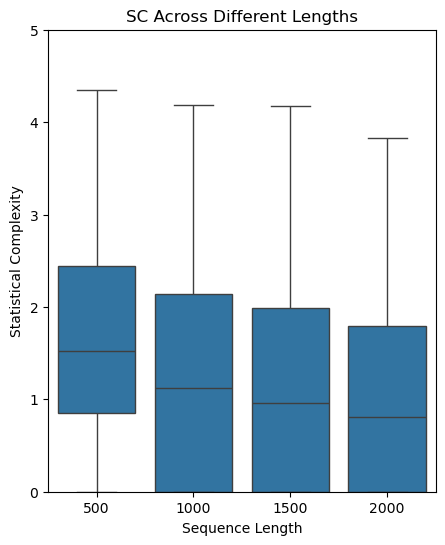

In [23]:
# Extract statistical complexities by length
stat_complexities_by_length = {}
for (length, lambda_val, sigma_val), (stat_complexities, _) in results.items():
    if length not in stat_complexities_by_length:
        stat_complexities_by_length[length] = []
    stat_complexities_by_length[length].extend(stat_complexities)

# Separate box plot for Statistical Complexity across different lengths
plt.figure(figsize=(5, 6))
stat_data = []
lengths = []
for length, stat_complexities in stat_complexities_by_length.items():
    stat_data.extend(stat_complexities)
    lengths.extend([length] * len(stat_complexities))
sns.boxplot(x=lengths, y=stat_data)
plt.title('SC Across Different Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Statistical Complexity')
plt.ylim(0, 5)

plt.show()